<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook 6</p></tp>
            <tp><p style="font-size:150%;text-align:center">Juegos (2/2) </p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

## Objetivo

En este notebook estudiaremos cómo evaluar un tablero de un juego competitivo de dos jugadores cuando no sabemos cómo definir una función de evaluación adecuada, o no contamos con suficiente conocimiento experto para hacerlo. La estrategia que vamos a estudiar también es útil cuando el factor de ramificación es muy grande (como en el juego de Go), pues en estos casos la poda alfa-beta usualmente no es suficiente para obtener un algoritmo eficiente. La estrategia que estudiaremos se llama la búsqueda en árboles Monte Carlo (Monte Carlo Tree Search). 

Adaptado de Russell & Norvig (2020), sección 5.4.

## Secciones

Desarrollaremos la explicación de la siguiente manera:

* [Simulación de juego](#sim)
* [Selección de nodos](#seleccion).
* [Back-propagation](#back-p)
* [Exploración vs explotación](#upper-confidence-bound).


## Simulación de juego <a class="anchor" id="sim"></a>

Hay juegos para los cuales resulta difícil definir una función de evaluación heurística, la cual proporciona una medida de qué tan favorable es un tablero dado para cada jugador (cuanto más grande la evaluación, más favorable para MAX; cuanto más pequeño, más favorable para MIN). En estas situaciones, se ha encontrado muy útil hacer una exploración aleatoria de las opciones de juego en un tablero. La evaluación del tablero se obtendrá a partir de la utilidad promedio de los resultados obtenidos de la exploración. Esta estrategia ha sido llamada Búsqueda en Árboles Monte Carlo (MCTS por sus siglas en inglés). El objetivo aquí es realizar una exploración aleatoria, mediante la simulación del juego, para saber cuáles acciones (o secuencias de acciones) llevan más frecuentemente a la victoria. Los pasos más importantes son la simulación de juego (esta sección), la selección de nodos, y la retro-propagación de la utilidad.

Comenzaremos con las simulaciones. Para hacer una simulación, el computador toma el tablero y selecciona una jugada posible para el jugador correspondiente, luego obtiene el tablero resultado y selecciona una jugada posible para el otro jugador, y así hasta terminar el juego. Observe que proceder de esta manera es construir un camino desde el tablero inicial hasta un estado terminal. En esta simulación no se expande un árbol, pues no se consideran todas las opciones de juego en cada paso; solamente consideramos una. 

La selección de jugadas puede hacerse de manera aleatoria, o puede utilizarse para ello una 'política de juego', si se dispone de esta información. Esta política puede provenir de conocimiento experto; sin embargo, también se han usado técnicas de deep learning para encontrar buenas jugadas, especialmente en el ajedrez y en el juego de Go.

### Simulación aleatoria

En la simulación aleatoria, cada jugada de cada jugador se hace de manera aleatoria entre las acciones posibles en el tablero correspondiente. Observe que basar la exploración del juego en jugadas aleatorias permitirá responder a la pregunta "¿cuál es la mejor jugada si ambos jugadores juegan de manera aleatoria?". Para algunos juegos, responder esto no es suficiente para encontrar la mejor jugada. Por eso en un momento volveremos a la inclusión de una política de juego.

Para hacer la explicación en este notebook, usaremos de nuevo nuestro juego de hacer mate con torre y rey contra rey solitario.

In [1]:
from ambientes import ReyTorreRey

Una posible implementación de la simulación aleatoria es la siguiente. Primero se define una función para hacer un ply aleatorio, esto es, para escoger una acción aleatoria de un jugador en un tablero dado:

In [2]:
from random import choice

def hacer_ply_aleatorio(juego, estado, d, max_lim):
    if d >= max_lim:
        return 'cutoff', estado
    elif juego.es_terminal(estado):
        return juego.utilidad(estado, juego.a_jugar(estado)), estado
    else:
        acciones = juego.acciones(estado)
        a = choice(acciones)
        return None, juego.resultado(estado, a)

Comprobamos el funcionamiento de los plys:

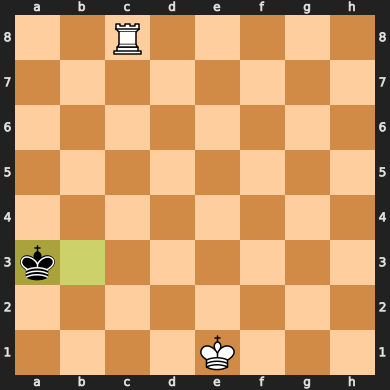

Juego terminado. ¡Ganan las negras!


In [5]:
from time import sleep
from IPython.display import clear_output

roo = ReyTorreRey(jugador='blancas', tablero_inicial=2)
s = roo.estado_inicial
display(s)
max_lim = 10
u = None
d = 0
while u is None:
    sleep(.5)
    u, s = hacer_ply_aleatorio(roo, s, d, max_lim)
    d += 1
    clear_output(wait=True)
    display(s)
    if u is not None:
        if u == 'cutoff':
            # Si las blancas no hacen mate, es como si ganaran las negras
            print('Juego terminado. ¡Ganan las negras!')
        elif u <= 0: 
            # Si tablas, es como si ganaran las negras
            print('Juego terminado. ¡Ganan las negras!')
        else:
            print('Juego terminado. ¡Ganan las blancas!')

Ahora solo falta empaquetar en una función `simulacion_aleatoria` el hacer un ply aleatorio tantas veces como sea permitido. Al finalizar obtenemos la utilidad del tablero resultante. Observe que el problema de mate con torre y rey nos permite simplificar la situación. Si el juego no se termina después de la cantidad de plys permitidos, diremos que ganan las negras, toda vez que quien debe hacer mate son las blancas. En general, en un juego diferente, habría que pensar cómo evaluar el tablero obtenido después de realizar la cantidad máxima de plys permitidos y no haber finalizado el juego.

In [6]:
def simulacion_aleatoria(juego, estado, max_lim=40):
    if juego.es_terminal(estado):
        u = juego.utilidad(estado, juego.a_jugar(estado))
    else:
        u = None
        s = estado
        d = 0
        while u is None:
            u, s = hacer_ply_aleatorio(juego, s, d, max_lim)
            d += 1
    if u == 'cutoff':
        # Si las blancas no hacen mate, es como si ganaran las negras
        return {'blancas':0, 'negras':1}
    elif u <= 0:
        # Si tablas, es como si ganaran las negras
        return {'blancas':0, 'negras':1}
    else:
        return {'blancas':1, 'negras':0}

Comprobamos el funcionamiento de la simulación:

In [19]:
roo = ReyTorreRey(jugador='blancas', tablero_inicial=2)
s = roo.estado_inicial
simulacion_aleatoria(roo, s, 100)

{'blancas': 0, 'negras': 1}

### Simulación con política de juego

Jugar de manera aleatoria en el mate con torre y rey contra rey solitario pocas veces lleva a obtener el mate. Es necesario guiar un poco las acciones de los jugadores para que la simulación sea útil. No se necesita un examen muy profundo para darse cuenta de que la única manera de obtener un mate con torre y rey requiere que las acciones del rey negro estén limitadas por el rey blanco y por la orilla del tablero. Esto se obtiene cuando ambos reyes están uno en frente del otro (oposición) y el rey negro se encuentra en una orilla. Sólo en esta situación puede la torre hacer mate. Resulta natural, entonces, favorecer las acciones de las blancas que lleven a que el rey negro tenga que moverse hacia la orilla, así como aquellas que favorecen la oposición de los reyes. El rey negro buscará jugadas que determinen justo lo contrario de esto.

In [20]:
import numpy as np

def feval(juego, board):
    th1 = 1
    th2 = 10
    # Contamos oposición
    fila_rey_negro, columna_rey_negro = juego.casilla_pieza(board, 'k')
    fila_rey_blanco, columna_rey_blanco = juego.casilla_pieza(board, 'K')
    oposicion = 1/(np.abs(fila_rey_blanco-fila_rey_negro) + np.abs(columna_rey_blanco-columna_rey_negro) + 1)
    # Contamos rey negro en borde
    rey_negro_fila = (4 - fila_rey_negro if fila_rey_negro < 4 else (fila_rey_negro % 4) + 1) - 4 
    rey_negro_columna = (4 - columna_rey_negro if columna_rey_negro < 4 else (columna_rey_negro % 4)) - 4
    rincon = max(rey_negro_fila, rey_negro_columna)
    return th1 * oposicion + th2 * rincon

def feval_blancas(juego, board):
    if juego.es_terminal(board):
        return juego.utilidad(board, juego.a_jugar(board))
    else:
        acciones = juego.acciones(board)
        estados = [juego.resultado(board, a) for a in acciones]
        valores = [feval(juego, e) for e in estados]
        return min(valores)

def hacer_ply_policy(juego, board, d, max_lim=40):
    if d >= max_lim:
        return 0, board
    elif juego.es_terminal(board):
        return juego.utilidad(board, juego.a_jugar(board)), board
    else:
        acciones = juego.acciones(board)
        estados = [juego.resultado(board, a) for a in acciones]
        if juego.a_jugar(board) == 'negras':
            valores = [feval(juego, e) for e in estados]
            indice = np.argmin(valores)
        elif juego.a_jugar(board) == 'blancas':
            valores = [feval_blancas(juego, e) for e in estados]
            indice = np.argmax(valores)
        a = acciones[indice]
        return None, juego.resultado(board, a)

Revisamos el funcionamiento de las acciones realizadas mediante la política descrita anteriormente. Observe que el rey negro es llevado a la orilla y el rey blanco busca la oposición, mientras que el negro trata de evitarla:

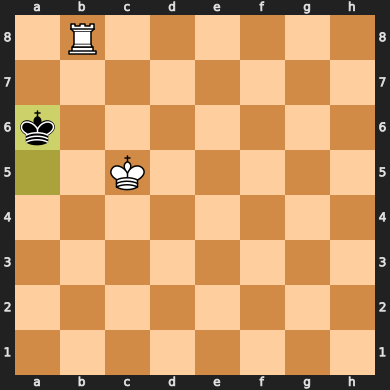

Juego terminado. ¡Ganan las negras!


In [21]:
from time import sleep
from IPython.display import clear_output

roo = ReyTorreRey(jugador='blancas', tablero_inicial=2)
s = roo.estado_inicial
display(s)
max_lim = 8
u = None
d = 0
while u is None:
    sleep(.5)
    u, s = hacer_ply_policy(roo, s, d, max_lim)
    d += 1
    clear_output(wait=True)
    display(s)
    if u is not None:
        if u == 'cutoff':
            # Si las blancas no hacen mate, es como si ganaran las negras
            print('Juego terminado. ¡Ganan las negras!')
        elif u <= 0: 
            # Si tablas, es como si ganaran las negras
            print('Juego terminado. ¡Ganan las negras!')
        else:
            print('Juego terminado. ¡Ganan las blancas!')

De nuevo, empaquetamos el hacer plys en una función `simulacion_policy` y comprobamos su funcionamiento:

In [22]:
def simulacion_policy(juego, board, max_lim=110):
    if juego.es_terminal(board):
        u = juego.utilidad(board, juego.a_jugar(board))
    else:
        u = None
        s = board
        d = 0
        while u is None:
            u, s = hacer_ply_policy(juego, s, d, max_lim)
            d += 1
    if u > 0:
        return {'blancas':1, 'negras':0}
    else:
        return {'blancas':0, 'negras':1} # Empatar le sirve a las negras

In [23]:
roo = ReyTorreRey(jugador='blancas', tablero_inicial=2)
s = roo.estado_inicial
simulacion_policy(roo, s)

{'blancas': 1, 'negras': 0}

## Selección de nodos <a class="anchor" id="seleccion"></a>

Recordemos que nuestro objetivo es ranquear las jugadas posibles dado un tablero. Para realizar esto, vamos a buscar jugadas que frecuentemente llevan a la victoria. Observe que estamos en una situación en donde no tenemos recursos computacionales para explorar todas las jugadas posibles. Así pues, nuestra exploración cubrirá sólo una porción pequeña del árbol de confrontación. Si esta exploración se hace de manera completamente aleatoria, la información resultante usualmente no resulta muy útil. Más bien, la idea es realizar la exploración de manera que se exploten las jugadas más prometedoras que se vayan encontrado, de tal manera que tengamos más evidencia sobre ellas. Para ello se tratará de balancear el dilema entre explorar nuevas opciones y explotar aquellas más prometedoras.

Para guiar este proceso usaremos una estructura de árbol, en el cual cada nodo guarda un tablero y la utilidad obtenida hasta ahora por el jugador respectivo. La utilidad la obtenemos mediante la simulación que implementamos en la sección anterior. La idea es ir expandiendo los nodos más prometedores, es decir, aquellos en donde las simulaciones han mostrado mayor utilidad para el jugador respectivo. De esta manera, los recursos computacionales se enfocan en pocas combinaciones de jugadas, que se exploran más frecuentemente que otras menos prometedoras.

Comenzaremos con un árbol cuyo único nodo es la raíz. Para simplificar la exposición, iremos creciendo este árbol expandiendo los nodos de manera aleatoria. No obstante, la idea es expandir el árbol de tal manera que explotemos los nodos más prometedores. Sobre esto volveremos más adelante, cuando ataquemos el problema de la [exploración vs explotación](#monte-carlo).

Comenzamos con nuestra estructura de nodos, que es una estructura recursiva basada en nodos con los siguientes atributos:

* **juego**: la clase que usamos para implementar nuestro juego.
* **estado**: el tablero correspondiente al nodo.
* **utilidad**: en este caso, la frecuencia con que el jugador correspondiente gana el juego en las simulaciones que se hacen desde este estado o sus descendientes.
* **playouts**: cantidad de simulaciones que se hacen desde este estado o sus descendientes.
* **madre**: el nodo del que proviene.
* **accion**: acción usada para obtener el nodo en cuestión desde su nodo madre.
* **hijos**: lista de nodos hijos.

La siguiente es una posible implementación de esta estructura en python:

In [24]:
import numpy as np
from random import sample

def divi(x, y):
    return str(x/y) if y != 0 else '0'

class Arbol:
    def __init__ (self, juego, estado, utilidad, playouts, madre, accion, hijos, tam_exp = 20):
        self.juego = juego
        self.estado = estado
        self.utilidad = utilidad
        self.playouts = playouts
        self.madre = madre
        self.accion = accion
        self.hijos = hijos
    
    def __str__(self):
        cadena = "Estado:\n" + str(self.estado) + "\n"
        cadena += "Profundidad: " + str(self.profundidad()) + "\n"
        if self.madre is not None:
            cadena += "Madre:\n" + str(self.madre.estado) + "\n"
            cadena += "Proviene de: " + str(self.madre.estado.san(self.accion)) + "\n"
        else:
            cadena += "Madre: None\n"
            cadena += "Proviene de: None\n"
        if self.juego.a_jugar(self.estado) == 'blancas':
            cadena += "Utilidad de las negras aquí:\n" + str(self.utilidad) + ":" + str(self.playouts) + "(" + divi(self.utilidad, self.playouts) + ")" + "\n"
        elif self.juego.a_jugar(self.estado) == 'negras':
            cadena += "Utilidad de las blancas aquí:\n" + str(self.utilidad) + ":" + str(self.playouts) + "(" + divi(self.utilidad, self.playouts) + ")" + "\n"
        cadena += "A jugar: " + self.juego.a_jugar(self.estado) + "\n"
        cadena += "Hijos:"
        for h in self.hijos:
            cadena += "\nAcción " + str(self.estado.san(h.accion)) + " con utilidad " + str(h.utilidad) + ":" + str(h.playouts) + "(" + divi(h.utilidad, h.playouts) + ")"
        return cadena
    
    def profundidad(self):
        if self.madre is None:
            return 0
        else:
            return 1 + self.madre.profundidad()
    
    def expandir(self, tam_exp = 10):
        acciones_posibles = self.juego.acciones(self.estado)
        if len(acciones_posibles) == 0:
            return self
        else:
            acciones_vistas = [self.estado.san(hijo.accion) for hijo in self.hijos]
            acciones = [a for a in acciones_posibles if self.estado.san(a) not in acciones_vistas]
            if len(acciones) > tam_exp:
                acciones_seleccionadas = sample(acciones, tam_exp)
            else:
                acciones_seleccionadas = acciones
            for a in acciones_seleccionadas:
                hijo = Arbol(self.juego, self.juego.resultado(self.estado, a), 0, 0, self, a, [])
                self.hijos.append(hijo)
            return choice(self.hijos)

In [25]:
arbol = Arbol(roo, s, 0, 0, None, None, [])
print(arbol)

Estado:
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. k . K . . . .
. . . . . . . .
Profundidad: 0
Madre: None
Proviene de: None
Utilidad de las negras aquí:
0:0(0)
A jugar: blancas
Hijos:


Es importante tomarse unos segundos para examinar la visualización del árbol anterior, el cual consta solo de un nodo raíz. No es necesario prestar mucha atención a la utilidad todavía; ya volveremos sobre esto más adelante.

En la clase `Arbol` hemos incluido hasta ahora dos métodos:

* **profundidad**: que nos dice a qué altura está el nodo.
* **expandir**: que expande un nodo con tantos hijos como permita el parámetro `tam_exp`. Lo que hace este método es seleccionar una muestra aleatoria de tamaño `tam_exp` de todas las acciones posibles y añadir los nodos respectivos a la lista de hijos.

Al correr la siguiente celda podemos ver que la visualización del nodo raíz del árbol nos presenta una lista de acciones, cada una de las cuales se ha expandido como un nodo hijo:

In [26]:
arbol.expandir(tam_exp=2)
print(arbol)

Estado:
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. k . K . . . .
. . . . . . . .
Profundidad: 0
Madre: None
Proviene de: None
Utilidad de las negras aquí:
0:0(0)
A jugar: blancas
Hijos:
Acción Ke2 con utilidad 0:0(0)
Acción Rc4 con utilidad 0:0(0)


La selección de una hoja la implementaremos mediante el siguiente método. Observe que usamos la librería `types` para incorporar el método directamente en el objeto ya instanciado de la clase `Arbol`:

In [27]:
from types import MethodType

def seleccionar_aleatorio(self):
    n = self
    while len(n.hijos) > 0:
        n = choice(n.hijos)
    return n

arbol.seleccionar_aleatorio = MethodType(seleccionar_aleatorio, arbol)

Ahora hacemos un bucle para iterar la selección aleatoria de una hoja y expandirla con dos hijos cada vez. Observe que al correr el método `seleccionar_aleatorio` sobre la raíz del árbol se obtiene una hoja del árbol (no un hijo de la raíz):

In [28]:
for i in range(10):
    hoja = arbol.seleccionar_aleatorio() 
    hoja.expandir(tam_exp=2)
    
print(arbol.seleccionar_aleatorio())

Estado:
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
k . . . K . . .
. . R . . . . .
Profundidad: 4
Madre:
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . K . . .
k . R . . . . .
Proviene de: Ka2
Utilidad de las negras aquí:
0:0(0)
A jugar: blancas
Hijos:


Dedique unos segundos para entender bien la visualización anterior.

Esta es la idea general de la selección de nodos, aunque hecha de manera aleatoria. La selección que nos interesa será una que permita atender el dilema de explorar el árbol de confrontación y a la vez explotar los nodos más prometedores que la búsqueda vaya encontrando. Por simplicidad de la exposición, nos quedaremos por el momento con la selección aleatoria. Más adelante volveremos sobre un mejor método de selección, cuando tengamos una manera de evaluar qué tan prometedor es un nodo.

## Retro propagación de la utilidad <a class="anchor" id="back-p"></a>

La estrategia de búsqueda procederá iterando los siguientes pasos:

* Selección de una hoja del árbol.
* Expansión de la hoja y selección aleatoria de uno de sus hijos, que llamaremos `n`.
* Simulación del juego desde `n`, obteniendo así un resultado.
* Retro propagación del resultado de la simulación hacia los ancestros de `n`.

En la siguiente figura vemos un ejemplo de un paso de esta iteración:

<img src="./imagenes/backpropagation.png" width="550"/>

Es importante notar varias cosas aquí. Observe que la utilidad la vamos a llevar en términos de frecuencia relativa de victorias para el jugador respectivo, que se obtienen desde la simulación de juego. Esto es, supongamos un nodo `n` en que le toca el turno a las blancas. Este nodo tendrá una relación, digamos 60:79, que representa que en 79 simulaciones, en 60 de ellas las blancas han sido victoriosas. Estas 79 simulaciones se han corrido algunas desde `n` y otras desde uno de sus descendientes. Los resultados obtenidos en simulaciones corridas desde un descendiente de un nodo se retro propagan hasta la raíz, afectando así a todos sus antecesores.

La siguiente es una posible implementación de esta función de retro propagación de la utilidad:

In [29]:
def retro_propagar(self, resultado):
    if self.juego.a_jugar(self.estado) == 'negras':
        jugador = 'blancas'
    elif self.juego.a_jugar(self.estado) == 'blancas':
        jugador = 'negras'
    self.playouts += 1
    self.utilidad += resultado[jugador]
    if self.madre is not None:
        self.madre.retro_propagar(resultado)

Ahora observamos cómo funciona la iteración de estos cuatro pasos:

In [30]:
from time import time
time_start = time()
juego = ReyTorreRey(jugador='blancas', tablero_inicial=2)
estado = juego.estado_inicial
max_time = 5
tam_exp = 3
max_lim = 40
setattr(Arbol, "seleccionar_aleatorio", seleccionar_aleatorio)
setattr(Arbol, "retro_propagar", retro_propagar)
arbol = Arbol(juego, estado, 0, 0, None, None, [])
time_is = time()
while time_is - time_start < max_time:
    n = arbol.seleccionar_aleatorio()
    hijo = n.expandir(tam_exp)
    u = simulacion_aleatoria(juego, hijo.estado, max_lim)
    hijo.retro_propagar(u)
    time_is = time()
print(arbol)

Estado:
. . R . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
. k . K . . . .
. . . . . . . .
Profundidad: 0
Madre: None
Proviene de: None
Utilidad de las negras aquí:
757:766(0.9882506527415144)
A jugar: blancas
Hijos:
Acción Rc2+ con utilidad 2:264(0.007575757575757576)
Acción Ke1 con utilidad 1:238(0.004201680672268907)
Acción Rb8+ con utilidad 6:264(0.022727272727272728)


Dedique unos segundos para entender la visualización anterior, obtenidad al iterar, durante 5 segundos, los pasos de seleccionar un nodo, expandirlo, hacer una simulación desde uno de sus hijos, y retro propagar el resultado. Sobre todo, observe que las cantidades de simulaciones en cada una de las acciones no son muy diferentes entre sí. Esto ocurre porque el proceso de  selección se hace de manera aleatoria uniforme. En la próxima sección veremos cómo sesgar la selección para escoger más veces aquellos nodos que van pareciendo más prometedores.

**Ejercicio 1:**

Visualice el nodo correspondiente a la acción más prometedora, es decir, aquella que tiene una frecuencia relativa de victorias mayor que las demás. Observe que en este nuevo nodo aumenta la profundidad y disminuyen la cantidad de simulaciones totales. No obstante, las cantidades no son muy diferentes entre nodos. Observe también que la utilidad es relativa al jugador al que le corresponde el turno.

---

## Exploración vs explotación <a class="anchor" id="upper-confidence-bound"></a>

En un mundo ideal, la solución a la pregunta "¿cuál es la mejor jugada?" se obtiene después de encontrar a dónde nos lleva cada una de las opciones posibles. Esto fue posible en el triqui, pero son más las veces en que no podemos hacer esto que en las que sí. Para responder la pregunta debemos utilizar sabiamiente los recursos computacionales que tengamos a nuestra disposición. La exploración aleatoria tiene la dificultad de que usualmente no es la manera más eficiente de usar los recursos, pues podemos invertir muchos en jugadas que no son buenas. 

Es importante observar que toda exploración que no lleve a considerar todo el árbol de confrontación tendrá un defecto importante. Al explorar sólo un subconjunto de las jugadas posibles, siempre se corre el riesgo de dejar la jugada óptima por fuera de toda consideración. Nuestra estrategia debe vivir con esta dificultad.

Por el lado amable, lo que podemos hacer es privilegiar la búsqueda hacia aquellos nodos que hasta ahora han mostrado ser más prometedores. Sin embargo, aquí se corre otro riesgo. Ahora puede que nuestro árbol contenga la jugada óptima `a`, pero que no sea explorada porque los recursos se fueron a explorar otras jugadas que son buenas, pero no tan buenas como `a`. Este problema se conoce como el dilema entre explorar opciones y explotar aquellas que hasta ahora sabemos que son buenas. Enfrentamos ese dilema todos los días. Por ejemplo, cada vez que salimos a almorzar nos hacemos la siguiente pregunta: ¿Repetimos ese restaurante que es relativamente bueno o vamos a otro que hasta ahora desconocemos? Cuando abrimos Spotify ¿seleccionamos las canciones que nos gustan o escuchamos un grupo nuevo? La situación puede ser más complicada aún: ¿Sigo con esta novia que hasta ahora está bien, o le doy chance a esta otra chica que, por lo menos en principio, podría ser mejor?

Vamos a ver cómo enfrentar este problema de explotación vs exploración mediante una fórmula numérica que podamos afinar y adaptar a nuestro problema. Debo decir que es una buena solución para los juegos competitivos; desafortunadamente para ustedes, aún no me he topado con una solución para el problema de encontrar pareja. Sobre esto puede servirles la <a href="https://www.brainpickings.org/2012/08/14/darwin-list-pros-and-cons-of-marriage/">lista de chequeo de Charles Darwin para el matrimonio</a>.

### Upper confidence bound formula

Sea $n$ un nodo y suponga que 

* $U(n)$ es la utilidad acumulada de las simulaciones desde $n$ o uno de sus descendientes.
* $N(n)$ es el número total de simulaciones realizadas desde $n$ o uno de sus descendientes.
* $C$ es la constante que permite balancear la exploración vs la explotación.

Entonces la fórmula de cota de confianza superior (UCB1) es la siguiente:

$$UCB1(n)=\frac{U(n)}{N(n)} + C\sqrt{\frac{\log(N(n.madre))}{N(n)}}$$

El término de la izquierda es el promedio de la utilidad, que en nuestro caso se reduce a la frecuencia relativa de victorias. El término de la derecha representa una relación entre exploración y explotación. Es inversamente proporcional a la cantidad de veces que $n$ ha sido explorado y directamente proporcional a la cantidad de veces que $n.madre$ ha sido explorado. Es importante notar que el denominador de este término crece mucho más rápido que su numerador, así que el término tenderá hacia cero a medida que $N(n)$ crezca. Esto es, el término de la derecha tiende a desaparecer a medida que el nodo $n$ es explorado más veces.

Esta fórmula puede entenderse también de la siguiente manera. Si $n$ no ha sido explorado muchas veces, el valor de $UCB1(n)$ tiende a ser igual a $C$. Para nodos que han sido explorados muchas veces, el valor de $UCB1(n)$ tiende a ser igual a la utilidad promedio de $n$ (es decir, $\frac{U(n)}{N(n)}$).  

In [35]:
print("Valor de UBC1 para un nodo poco explorado:")
n = 1
m = 2*n
print(np.sqrt(np.log(m) / n))

Valor de UBC1 para un nodo poco explorado:
0.8325546111576977


In [37]:
from time import sleep
from IPython.display import clear_output

# Nodo cada vez más explorado:
for n in range(1, 1000, 10):
    clear_output(wait=True)
    m = 2*n
    print("Valor de UBC1 a medida que el nodo se explora más veces:")
    print(np.sqrt(np.log(m) / n))
    sleep(.1)

Valor de UBC1 a medida que el nodo se explora más veces:
0.08752604752787942


Vamos a implementar esta fórmula como un método de nuestra clase `Arbol`, el cual utilizaremos para un nuevo método de selección. Este nuevo método, `seleccionar_ucb`, irá descendiendo en el árbol escogiendo en cada nodo $n$ el hijo con mayor valor $UCB1(n)$:

In [38]:
def ucb(self, C=1):
    if self.madre is None:
        return 0
    elif self.playouts != 0:
        explotacion = self.utilidad / self.playouts
        exploracion = C * np.sqrt(np.log(self.madre.playouts + 1) / (self.playouts + 1))
        return explotacion + exploracion
    else:
        return C * np.sqrt(np.log(self.madre.playouts + 1))
    
def seleccionar_ucb(self, C=1):
    n = self
    while len(n.hijos) > 0:
        hijos_ucb = [h.ucb(C) for h in n.hijos]
        indice = np.argmax(hijos_ucb)
        n = n.hijos[indice]
    return n

setattr(Arbol, "ucb", ucb)
setattr(Arbol, "seleccionar_ucb", seleccionar_ucb)

**Ejercicio 2:**

Corra la siguiente celda con distintos valores de $C$ y examine el resultado. 

In [ ]:
from time import time
time_start = time()
juego = ReyTorreRey(jugador='blancas', tablero_inicial=2)
estado = juego.estado_inicial
max_time = 5
tam_exp = 3
max_lim = 40

#################################################################
# Cambiar varias veces este valor y examinar el resultado. 
# Valores sugeridos (1, .5, .1)
C = .4
#################################################################

setattr(Arbol, "seleccionar_ucb", seleccionar_ucb)
setattr(Arbol, "retro_propagar", retro_propagar)
arbol = Arbol(juego, estado, 0, 0, None, None, [])
time_is = time()
while time_is - time_start < max_time:
    n = arbol.seleccionar_ucb(C)
    hijo = n.expandir(tam_exp)
    u = simulacion_aleatoria(juego, hijo.estado, max_lim)
    hijo.retro_propagar(u)
    time_is = time()
print(arbol)

Observe que para valores más pequeños de $C$, las simulaciones se concentran en una sola opción, que resulta tener la mayor utilidad. Para valores grandes de $C$, la fórmula tiene a coincidir con la selección aleatoria, ignorando la utilidad. Un valor de $C$ no debe darse por sentado, y debe adaptarse al problema que se desea resolver.

---

## Un engine con MCTS

Ya estamos listos para crear el engine, que buscará la mejor jugada usando la estrategia de búsqueda de árboles Monte Carlo.

Definimos primero un método que seleccione el hijo de la raíz con mejor utilidad:

In [39]:
def escoger_accion(self):
    valuaciones = [h.utilidad/h.playouts if h.playouts > 0 else 0 for h in self.hijos]
    indice = np.argmax(valuaciones)
    return self.hijos[indice].accion

setattr(Arbol, "escoger_accion", escoger_accion)

Ahora definimos la función que busca la mejor jugada, dado un tablero particular. Observe que esta vez estamos usando la simulación guiada por la política de juego. Si no, el engine no logrará hacer mate.

In [40]:
from time import time

def jugar_MCTS(juego, estado, max_time=20,  max_lim=50, tam_exp=10, C=.05):
    time_start = time()
    arbol = Arbol(juego, estado, 0, 0, None, None, [])
    time_is = time()
    while time_is - time_start < max_time:
        n = arbol.seleccionar_ucb(C)
        hijo = n.expandir(tam_exp)
        u = simulacion_policy(juego, hijo.estado, max_lim)
        hijo.retro_propagar(u)
        time_is = time()
    return arbol.escoger_accion()

¡Y ya estamos listos para jugar! Observe que hemos escogido unos parametros para `max_time`, `max_lim`, `tam_exp` y `C`. Estos valores los encontramos después de analizar los resultados de muchos intentos. En este punto, para una implementación particular, resulta útil una buena metodología de estudio de parámetros, como los que se ven en Machine Learning. 

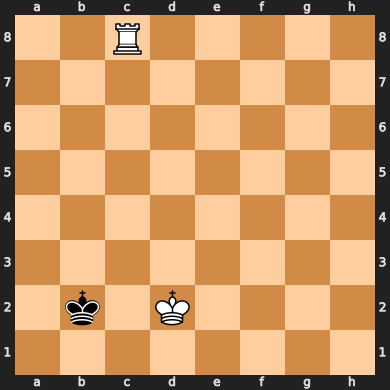

In [41]:
from ambientes import ReyTorreRey
from IPython.display import clear_output, display, Image
from time import sleep

roo = ReyTorreRey(tablero_inicial=2)
s = roo.estado_inicial
s

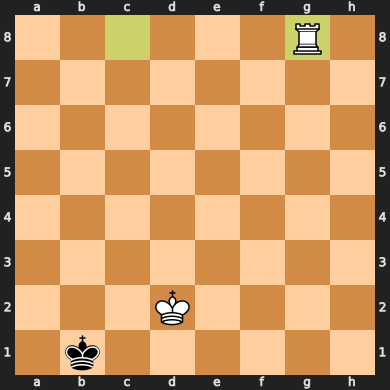

In [42]:
### Introduzca aquí su jugada y corra la celda
a = 'Kb1'
###################
s = roo.jugada_manual(s, a)
display(s)
if not roo.es_terminal(s):
    a = jugar_MCTS(roo, s, max_time=20,  max_lim=50, tam_exp=10, C=.05)
    s = roo.resultado(s, a)
    clear_output(wait=True)
    display(s)
    if roo.es_terminal(s):
        print('Juego terminado. ¡Ganan las blancas!')
else:
    jugador = roo.a_jugar(s)
    if roo.utilidad(s, jugador)==0:
        print('Juego terminado. ¡Tablas!')
    else:
        print('Juego terminado. ¡Ganan las negras!')

## En este notebook usted aprendió

* La simulación de juego, mediante las metodologías aleatoria y con política de juego.
* Cómo usar la idea de expandir un árbol para incorporar el dilema de exploración vs explotación en la búsqueda de una solución de un problema.
* Como crear un engine para hacer mate con torre y rey, con mínimo conocimiento sobre el ajedrez.